# Making a Database for Catherine out of the PopSyCLE Data with Natasha's OGLE cuts


> Here's the table with mock-OGLE EWS cuts implemented. The fields are merged and I also added in the companion parameters into this table for convenience. This is the `all_fields_Mrun_EWS_w_comp_params.fits` file.
>
> The columns of the event table are described here [https://popsycle.readthedocs.io/en/latest/source/popsycle_docs.html](https://popsycle.readthedocs.io/en/latest/source/popsycle_docs.html) (see the `event_table` description in `calc_events`, `refine_events`, and `refine_binary_events`). There's now also all the columns from the companion tables added. All the values for the binary lens companions are `comp_L_<column>` and for the source `comp_S_<column>` in the attached event table. If there's no companion the values are all set to `nan`.
>
> Note that we actually do include triples in a rudimentary way, but the companion parameters that are chosen for each lens and source here are the companion that corresponded to the lightcurve with the highest bump magnitude (`delta_m`). If you want the full detail of the companions and the lightcurves simulated, I attached the uncut companion and lightcurve tables. (see section 2.2.5 and Appendix B and C for details [https://ui.adsabs.harvard.edu/abs/2025ApJ...980..103A/abstract](https://ui.adsabs.harvard.edu/abs/2025ApJ...980..103A/abstract)).
> 
> Note also that since there are multiple fields combined here that the `obj_id_L`, `obj_id_S`, and `companion_ids` are no longer unique. You need to cross reference with the `field_id` column if you want to combine the tables.
> 
> I know this can be a bit complicated/confusing, so let me know if you have more questions!
>
> Best,
>
> Natasha


In [3]:
import pandas as pd
from astropy.io import fits
import numpy as np
from astropy.table import Table
import astropy.units as u
from isochrones.mist import MIST_EvolutionTrack
import warnings

# Initialize the isochrone model globally to avoid re-loading it every time.
# The first time this script runs, it may need to download data, which can be slow.
print("Initializing MIST isochrone models...")
# We're using the EvolutionTrack object now, not Isochrone
mist_track = MIST_EvolutionTrack()
print("MIST models loaded.")

# The WISE W1 filter is our proxy for Spitzer L-band.
# To see all available bands, run: 
print(mist_track.bands)

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


Initializing MIST isochrone models...
MIST models loaded.
['J', 'H', 'K', 'G', 'BP', 'RP', 'W1', 'W2', 'W3', 'TESS', 'Kepler']


## Load the `all_fields_Mrun_EWS_w_comp_params.fits` file

In [4]:
# Path to your FITS file
fits_file = 'data/all_fields_Mrun_EWS_w_comp_params.fits'

with fits.open(fits_file) as hdul:
    hdul.info()
    data = hdul[1].data
    # Convert to numpy array and change byte order to native (little-endian)
    data_array = np.array(data).byteswap().view(data.dtype.newbyteorder('='))
    df = pd.DataFrame(data_array)

df.head()

Filename: data/all_fields_Mrun_EWS_w_comp_params.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    342   5898R x 164C   [K, K, D, I, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, I, D, D, D, D, D, D, D, D, D, D, D, D, D, I, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, I, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 28A, 6A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


,obj_id_L,obj_id_S,age_L,popid_L,zams_mass_L,mass_L,systemMass_L,px_L,py_L,pz_L,...,comp_S_omega,comp_S_q,comp_S_sep,comp_S_P,comp_S_obj_id_L,comp_S_obj_id_S,comp_S_alpha,comp_S_phi_pi_E,comp_S_phi,comp_S_companion_idx
0,493856,11630673,9.647691,4,0.108094,0.108094,0.108094,1.046219,0.143427,0.084485,...,21.468162,0.665088,0.002759,0.004897,493856.0,11630673.0,145.180702,351.565936,153.614765,54.0
1,1871302,12431899,9.905573,6,0.310635,0.310635,0.310635,4.250701,0.585845,0.370213,...,225.949123,1.479937,1.569128,74.105185,1871302.0,12431899.0,45.090036,65.191924,339.898111,136.0
2,2250630,2903857,9.981004,6,0.635183,0.634982,0.634982,1.753730,0.247231,0.148651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2350514,2595276,9.997058,6,0.092799,0.092799,0.092799,0.496960,0.067016,0.040720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2529087,3000108,10.041392,7,0.116832,0.116832,0.116832,4.147659,0.586472,0.342430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
col_string = ', '.join(f'`{col}`' for col in df.columns)

with open('data/column_names.txt', 'w') as f:
    f.write(col_string)

**Column names:**

`obj_id_L`, `obj_id_S`, `age_L`, `popid_L`, `zams_mass_L`, `mass_L`, `systemMass_L`, `px_L`, `py_L`, `pz_L`, `vx_L`, `vy_L`, `vz_L`, `exbv_L`, `glat_L`, `glon_L`, `mbol_L`, `grav_L`, `teff_L`, `feh_L`, `rad_L`, `isMultiple_L`, `N_companions_L`, `rem_id_L`, `ubv_J_L`, `ubv_H_L`, `ubv_K_L`, `ubv_U_L`, `ubv_I_L`, `ubv_B_L`, `ubv_V_L`, `ubv_R_L`, `vr_L`, `mu_b_L`, `mu_lcosb_L`, `sep_L`, `age_S`, `popid_S`, `zams_mass_S`, `mass_S`, `systemMass_S`, `px_S`, `py_S`, `pz_S`, `vx_S`, `vy_S`, `vz_S`, `exbv_S`, `glat_S`, `glon_S`, `mbol_S`, `grav_S`, `teff_S`, `feh_S`, `rad_S`, `isMultiple_S`, `N_companions_S`, `rem_id_S`, `ubv_J_S`, `ubv_H_S`, `ubv_K_S`, `ubv_U_S`, `ubv_I_S`, `ubv_B_S`, `ubv_V_S`, `ubv_R_S`, `vr_S`, `mu_b_S`, `mu_lcosb_S`, `sep_S`, `theta_E`, `u0`, `mu_rel`, `t0`, `t_E`, `ubv_I_app_S`, `ubv_I_app_L`, `cent_glon_I_N`, `cent_glat_I_N`, `ubv_I_app_N`, `ubv_I_app_LSN`, `delta_m_I`, `f_blend_I`, `pi_rel`, `pi_E`, `pps_seed`, `gal_seed`, `n_peaks`, `bin_delta_m`, `tE_sys`, `tE_primary`, `primary_t`, `avg_t`, `std_t`, `asymmetry`, `companion_idx_list`, `field_id`, `observable_n_peaks`, `comp_L_zams_mass`, `comp_L_Teff`, `comp_L_L`, `comp_L_logg`, `comp_L_isWR`, `comp_L_mass`, `comp_L_phase`, `comp_L_metallicity`, `comp_L_m_ubv_U`, `comp_L_m_ubv_B`, `comp_L_m_ubv_V`, `comp_L_m_ubv_I`, `comp_L_m_ubv_R`, `comp_L_m_ukirt_H`, `comp_L_m_ukirt_K`, `comp_L_m_ukirt_J`, `comp_L_m_ztf_g`, `comp_L_m_ztf_r`, `comp_L_m_ztf_i`, `comp_L_log_a`, `comp_L_e`, `comp_L_i`, `comp_L_Omega`, `comp_L_omega`, `comp_L_q`, `comp_L_sep`, `comp_L_P`, `comp_L_obj_id_L`, `comp_L_obj_id_S`, `comp_L_alpha`, `comp_L_phi_pi_E`, `comp_L_phi`, `comp_L_companion_idx`, `comp_S_zams_mass`, `comp_S_Teff`, `comp_S_L`, `comp_S_logg`, `comp_S_isWR`, `comp_S_mass`, `comp_S_phase`, `comp_S_metallicity`, `comp_S_m_ubv_U`, `comp_S_m_ubv_B`, `comp_S_m_ubv_V`, `comp_S_m_ubv_I`, `comp_S_m_ubv_R`, `comp_S_m_ukirt_H`, `comp_S_m_ukirt_K`, `comp_S_m_ukirt_J`, `comp_S_m_ztf_g`, `comp_S_m_ztf_r`, `comp_S_m_ztf_i`, `comp_S_log_a`, `comp_S_e`, `comp_S_i`, `comp_S_Omega`, `comp_S_omega`, `comp_S_q`, `comp_S_sep`, `comp_S_P`, `comp_S_obj_id_L`, `comp_S_obj_id_S`, `comp_S_alpha`, `comp_S_phi_pi_E`, `comp_S_phi`, `comp_S_companion_idx`

Select every row where the `comp_S_mass` column (or any `comp_S_ column`) is NOT `nan`.

In [6]:
# Select columns that start with 'comp_S_'
comp_S_cols = [col for col in df.columns if col.startswith('comp_S_')]

# Select rows where any of these columns is not NaN
filtered_df = df[df[comp_S_cols].notna().any(axis=1)]

filtered_df.head()
comp_n = filtered_df.shape
N = df.shape
print(f"Number of rows with companion: {comp_n[0]}")
print(f"Number of rows without companion: {N[0] - comp_n[0]}")
print(f"Sample size: {N[0]}")
comp_percent = comp_n[0] / N[0] * 100
print(f"Percentage of rows with companion: {comp_percent:.2f}%")


Number of rows with companion: 2389
Number of rows without companion: 3509
Sample size: 5898
Percentage of rows with companion: 40.51%


## L-band Source Flux
lets do the gross bit. We want a L-band magnitude for our sources. That's not in the table. To find it we'll need to jump through some hoops.


### Overview

The primary goal in theis section is to set up a computational pipeline to accurately calculate the brightness of stars from Natasha's simulation as they would be seen by the Spitzer Space Telescope's infrared camera (specifically, in the L-band). To do this, we need to determine two key things for each star that aren't directly in the simulation data: its physical size (radius) and its full spectrum of light.

### The Packages and Their Roles

Here are the tools we're using and the job each one does:

* `numpy` and `astropy`: These are foundational packages for doing science with Python.
  - `numpy` is the workhorse for all numerical calculations.
  - `astropy.table` is used to read and manage the data from Natasha's FITS file.
  - `astropy.units` lets us attach physical units (like meters, years, or solar masses) to our numbers. This is a crucial bookkeeping step that helps prevent errors in our calculations.
* `isochrones`: This package is our tool for stellar evolution.
  The simulation tells us a star's mass, age, and distance, which we can use to get it's intrinsic L-band magnitude. The simulation also includes extinction, from which we can caluculate the apparent L-band magnitude.
  
  We use the isochrones package to access the [MIST stellar evolution models](https://waps.cfa.harvard.edu/MIST/model_grids.html#eeps). These models are the result of complex computer simulations that describe how stars of different masses and chemical compositions are born, live, and die.

  We feed a star's mass, age, and metallicity (its chemical makeup) into the MIST model. The model then returns the star's predicted brightness for that exact point in its life.

  This approach assumes that the MIST models are a good representation of how real stars behave. The bands available in the `isochrone` package do not include Spitzer IRAC, but Wise's W1 filter is comparable.

In [7]:
# The WISE W1 filter is our proxy for Spitzer L-band.
# not using this proxy makes life SIGNIFICANTLY more difficult
WISE_W1_FILTER_NAME = 'W1_mag'  # Why _mag? because their users hate me and want
# their live to be hard.

# DEPRICATED (but handy)
# This constant defines the ratio of extinction in W1 vs V-band.
# It's very similar to the L-band value.
# Predictions of an R(V) = 3.1 Fitzpatrick extinction law at E(B − V) = 0.4 for 
# a 7000-K source spectrum, assuming that SFD overpredict the true values of 
# E(B − V) by 14 per cent.
#R_W1 = 0.186  # Yuan, Liu, & Xiang (2013) Table 2 - Fitzpatrick (1999)

def get_apparent_L_mag(mass, age_gyr, feh, dist_kpc, ebv):
    """
    Calculates the apparent L-band magnitude for a star.

    This function uses the MIST_EvolutionTrack.generate() method to
    compute stellar properties based on mass, age, and metallicity,
    including the apparent W1 magnitude (used as a proxy for L-band).

    Parameters
    ----------
    mass : float
        Mass of the star in solar masses.
    age_gyr : float
        Age of the star in Gyr.
    feh : float
        Metallicity [Fe/H] in dex.
    dist_kpc : float
        Distance to the star in kiloparsecs.
    ebv : float
        Color excess E(B-V) for extinction.

    Returns
    -------
    float
        The final apparent magnitude.
    """
    if not all(np.isfinite([mass, age_gyr, feh, dist_kpc, ebv])):
        return np.nan

    # --- NO TRY/EXCEPT ---
    # Let it fail loudly if something goes wrong.

    # Convert our parameters to what .generate() expects.
    dist_pc = dist_kpc * 1000
    # AV is the total V-band extinction.
    AV = 3.1 * ebv
    
    # The .generate() method takes arrays, so we wrap our single values.
    # The key change is using 'mass' as the keyword, not 'masses'.
    properties = mist_track.generate(
        mass,  # This is the corrected argument name
        age_gyr, 
        feh,
        distance=dist_pc,
        AV=AV
    )
    
    # The result is a pandas DataFrame. We extract the magnitude we want.
    app_mag_final = properties[WISE_W1_FILTER_NAME].iloc[0]

    return app_mag_final

In [11]:
def process_source_magnitudes(df_in):
    """Calculates radii and L-band mags for binary source stars.

    Takes a DataFrame, identifies rows with binary sources, calculates the
    radius and L-band magnitude for both the primary and companion, and
    returns a new DataFrame with the results in new columns.

    Parameters
    ----------
    df_in : pandas.DataFrame
        Input DataFrame of lensing events. Assumed to have columns like
        `comp_S_mass`, `mass_S`, `age_S`, etc.

    Returns
    -------
    pandas.DataFrame
        A new DataFrame with four added columns: `rad_S_iso`,
        `rad_comp_S_iso`, `L_mag_S`, `L_mag_comp_S`.
    """
    # Work on a copy to ensure the original DataFrame is untouched
    df = df_in.copy()
    print("Processing binary SOURCE components...")
    
    if df.empty:
        print("No binary source events to process.")
        return df

    l_mags_primary = []
    l_mags_companion = []

    for i, row in enumerate(df.itertuples()):
        if i % 200 == 0 and i > 0:
            print(f"  ...processed {i}/{len(df)} source events")
            
        dist_s = np.sqrt(row.px_S**2 + row.py_S**2 + row.pz_S**2)
        mag_s = get_apparent_L_mag(row.mass_S, row.age_S, row.feh_S, dist_s, row.exbv_S)
        l_mags_primary.append(mag_s)
        
        mag_comp_s = get_apparent_L_mag(row.comp_S_mass, row.age_S, row.comp_S_metallicity, dist_s, row.exbv_S)
        l_mags_companion.append(mag_comp_s)

    
    print("Finished processing source components.")
    df.loc[:, 'L_mag_S'] = l_mags_primary
    df.loc[:, 'L_mag_comp_S'] = l_mags_companion
    
    return df

In [8]:
def process_lens_magnitudes(df_in):
    """Calculates radii and L-band mags for lens stars.

    Takes a DataFrame, identifies rows with luminous lenses (M > 0.1 Msun),
    calculates the radius and L-band magnitude for both the primary lens
    and its potential companion, and returns a new DataFrame with the
    results in new columns.

    Parameters
    ----------
    df_in : pandas.DataFrame
        Input DataFrame of lensing events. Assumed to have columns like
        `mass_L`, `age_L`, etc.

    Returns
    -------
    pandas.DataFrame
        A new DataFrame with four added columns: `rad_L_iso`,
        `rad_comp_L_iso`, `L_mag_L`, `L_mag_comp_L`.
    """
    # Work on a copy to ensure the original DataFrame is untouched
    df = df_in.copy()
    print("Processing LENS components...")
    
    mask = df['mass_L'] >= 0.11  # get weird artefacts from the isochrones if we 
                                 # go down any lower
    subset_df = df[mask]

    if subset_df.empty:
        print("No luminous lens events to process.")
        return df

    l_mags_primary = []
    l_mags_companion = []

    for i, row in enumerate(subset_df.itertuples()):
        if i % 500 == 0 and i > 0:
             print(f"  ...processed {i}/{len(subset_df)} lens events")
        dist_l = np.sqrt(row.px_L**2 + row.py_L**2 + row.pz_L**2)

        mag_l = get_apparent_L_mag(row.mass_L, row.age_L, row.feh_L, dist_l, row.exbv_L)
        l_mags_primary.append(mag_l)

        if pd.notna(row.comp_L_mass):
            mag_comp_l = get_apparent_L_mag(row.comp_L_mass, row.age_L, row.comp_L_metallicity, dist_l, row.exbv_L)
            l_mags_companion.append(mag_comp_l)
        else:
            l_mags_companion.append(np.nan)

    print("Finished processing lens components.")
    df.loc[mask, 'L_mag_L'] = l_mags_primary
    df.loc[mask, 'L_mag_comp_L'] = l_mags_companion
    
    return df

In [ ]:
# 1. Load transmission curve (you've already done this)
#transmission_csv = 'data/full_array_spec_resp_band_1_Spitzer_IRAC.csv'
#trans_data = np.genfromtxt(transmission_csv, names=['wavelength_um', 'response'])
#print(trans_data['wavelength_um'][:10])
#print(trans_data['response'][:10])

#bp_irac1 = SpectralElement(
#    Empirical1D,
#    points=trans_data['wavelength_um'] * u.micron,
#    lookup_table=trans_data['response']
#)

In [9]:
# You already have your 'filtered_df' from a previous cell
# It contains ONLY the binary source events.

# 2. Initialize new columns with NaN in a new DataFrame to be safe
binary_mag_df = filtered_df.copy()
for col in ['L_mag_S', 'L_mag_comp_S', 'L_mag_L', 'L_mag_comp_L']:
    binary_mag_df[col] = np.nan
print(binary_mag_df.head())

    obj_id_L  obj_id_S      age_L  popid_L  zams_mass_L    mass_L  \
0     493856  11630673   9.647691        4     0.108094  0.108094   
1    1871302  12431899   9.905573        6     0.310635  0.310635   
8     599168   6839414   9.436431        3     0.119087  0.119087   
14   7266164  14406514  10.041392        7     0.256288  0.256288   
15   8763501   2879043  10.000000        9     0.109863  0.109863   

    systemMass_L      px_L      py_L      pz_L  ...  comp_S_obj_id_L  \
0       0.108094  1.046219  0.143427  0.084485  ...         493856.0   
1       0.310635  4.250701  0.585845  0.370213  ...        1871302.0   
8       0.119087  4.568294  0.716986 -0.273133  ...         599168.0   
14      0.256288  6.094464  0.943885 -0.372823  ...        7266164.0   
15      0.109863  6.450657  0.986629 -0.416605  ...        8763501.0   

    comp_S_obj_id_S  comp_S_alpha  comp_S_phi_pi_E  comp_S_phi  \
0        11630673.0    145.180702       351.565936  153.614765   
1        12431899.0 

In [12]:
# 3. Run processing functions, creating a new DataFrame each time
# The first function now only needs to process the sources

# This will shut up specific warning from the isochrones package
warnings.filterwarnings("ignore", 
                        message="The 'delim_whitespace' keyword.*", 
                        category=FutureWarning)
warnings.filterwarnings("ignore", 
                        message="Starting with pandas version 3.0*", 
                        category=FutureWarning)
warnings.filterwarnings("ignore", 
                        message="Setting an item of incompatible dtype is deprecated.*", 
                        category=FutureWarning)

source_mags_added_df = process_source_magnitudes(binary_mag_df) 

Processing binary SOURCE components...


interpolating missing values in evolution tracks (feh=-4.0)': 100%|██████████| 196/196 [00:00<00:00, 2004.69it/s]
interpolating missing values in evolution tracks (feh=-3.5)': 100%|██████████| 196/196 [00:00<00:00, 830.72it/s]
interpolating missing values in evolution tracks (feh=-3.0)': 100%|██████████| 196/196 [00:00<00:00, 576.93it/s]
interpolating missing values in evolution tracks (feh=-2.5)': 100%|██████████| 196/196 [00:00<00:00, 538.69it/s]
interpolating missing values in evolution tracks (feh=-2.0)': 100%|██████████| 196/196 [00:00<00:00, 374.13it/s]
interpolating missing values in evolution tracks (feh=-1.75)': 100%|██████████| 196/196 [00:00<00:00, 792.92it/s]
interpolating missing values in evolution tracks (feh=-1.5)': 100%|██████████| 196/196 [00:00<00:00, 884.80it/s]
interpolating missing values in evolution tracks (feh=-1.25)': 100%|██████████| 196/196 [00:00<00:00, 1163.17it/s]
interpolating missing values in evolution tracks (feh=-1.0)': 100%|██████████| 196/196 [00:0

  ...processed 200/2389 source events
  ...processed 400/2389 source events
  ...processed 600/2389 source events
  ...processed 800/2389 source events
  ...processed 1000/2389 source events
  ...processed 1200/2389 source events
  ...processed 1400/2389 source events
  ...processed 1600/2389 source events
  ...processed 1800/2389 source events
  ...processed 2000/2389 source events
  ...processed 2200/2389 source events
Finished processing source components.


In [13]:
source_mags_added_df.head()

,obj_id_L,obj_id_S,age_L,popid_L,zams_mass_L,mass_L,systemMass_L,px_L,py_L,pz_L,...,comp_S_obj_id_L,comp_S_obj_id_S,comp_S_alpha,comp_S_phi_pi_E,comp_S_phi,comp_S_companion_idx,L_mag_S,L_mag_comp_S,L_mag_L,L_mag_comp_L
0,493856,11630673,9.647691,4,0.108094,0.108094,0.108094,1.046219,0.143427,0.084485,...,493856.0,11630673.0,145.180702,351.565936,153.614765,54.0,19.016959,20.506999,NaN,NaN
1,1871302,12431899,9.905573,6,0.310635,0.310635,0.310635,4.250701,0.585845,0.370213,...,1871302.0,12431899.0,45.090036,65.191924,339.898111,136.0,19.308044,NaN,NaN,NaN
8,599168,6839414,9.436431,3,0.119087,0.119087,0.119087,4.568294,0.716986,-0.273133,...,599168.0,6839414.0,139.491598,4.512076,134.979522,100.0,21.446788,23.441573,NaN,NaN
14,7266164,14406514,10.041392,7,0.256288,0.256288,0.256288,6.094464,0.943885,-0.372823,...,7266164.0,14406514.0,291.545738,239.443229,52.102509,478.0,17.815908,21.010838,NaN,NaN
15,8763501,2879043,10.000000,9,0.109863,0.109863,0.109863,6.450657,0.986629,-0.416605,...,8763501.0,2879043.0,75.633166,1.428655,74.204511,513.0,17.913674,23.551280,NaN,NaN


In [14]:
# The second function takes the result and adds the lens magnitudes
all_mags_df = process_lens_magnitudes(source_mags_added_df)

Processing LENS components...
  ...processed 500/1783 lens events
  ...processed 1000/1783 lens events
  ...processed 1500/1783 lens events
Finished processing lens components.


In [15]:
all_mags_df.head()

,obj_id_L,obj_id_S,age_L,popid_L,zams_mass_L,mass_L,systemMass_L,px_L,py_L,pz_L,...,comp_S_obj_id_L,comp_S_obj_id_S,comp_S_alpha,comp_S_phi_pi_E,comp_S_phi,comp_S_companion_idx,L_mag_S,L_mag_comp_S,L_mag_L,L_mag_comp_L
0,493856,11630673,9.647691,4,0.108094,0.108094,0.108094,1.046219,0.143427,0.084485,...,493856.0,11630673.0,145.180702,351.565936,153.614765,54.0,19.016959,20.506999,NaN,NaN
1,1871302,12431899,9.905573,6,0.310635,0.310635,0.310635,4.250701,0.585845,0.370213,...,1871302.0,12431899.0,45.090036,65.191924,339.898111,136.0,19.308044,NaN,20.064318,NaN
8,599168,6839414,9.436431,3,0.119087,0.119087,0.119087,4.568294,0.716986,-0.273133,...,599168.0,6839414.0,139.491598,4.512076,134.979522,100.0,21.446788,23.441573,22.477729,NaN
14,7266164,14406514,10.041392,7,0.256288,0.256288,0.256288,6.094464,0.943885,-0.372823,...,7266164.0,14406514.0,291.545738,239.443229,52.102509,478.0,17.815908,21.010838,21.095021,NaN
15,8763501,2879043,10.000000,9,0.109863,0.109863,0.109863,6.450657,0.986629,-0.416605,...,8763501.0,2879043.0,75.633166,1.428655,74.204511,513.0,17.913674,23.551280,NaN,NaN


In [23]:
# 4. Display results from your final DataFrame
print("\n--- Results ---")
print("Sample of calculated columns from 'all_mags_df':")
print(all_mags_df[['obj_id_S', 'L_mag_S', 'L_mag_comp_S', 'L_mag_L', 'L_mag_comp_L']].head(15))


--- Results ---
Sample of calculated columns from 'all_mags_df':
     obj_id_S    L_mag_S  L_mag_comp_S    L_mag_L  L_mag_comp_L
0    11630673  19.016959     20.506999        NaN           NaN
1    12431899  19.308044           NaN  20.064318           NaN
8     6839414  21.446788     23.441573  22.477729           NaN
14   14406514  17.815908     21.010838  21.095021           NaN
15    2879043  17.913674     23.551280        NaN           NaN
19     781174  19.090517     20.662988        NaN           NaN
22    2997726  18.378766     23.416593  19.871783     19.906825
23    9204316  17.118068     22.129464  17.627285     18.707285
24   15079738        NaN     19.505411        NaN           NaN
25   17193627        NaN     22.656230  19.773453     18.066544
31    5935159  19.644638     23.120217  20.011820           NaN
32   15830672  18.627181     22.028396        NaN           NaN
33   31868210  18.209827     19.071970        NaN           NaN
35  122449745  20.193172     18.155306

Now for the fun part: target acquisition. I've scanned the list. As I suspected, some of what you want is hiding in plain sight, and some of it requires a little... calculation. Amateurs look for a column; we *create* it.

### Your Target List & Where They're Hiding

Here is the map from what you want to the column names in that file.

  * **`M_L` (Lens Mass):** `mass_L`
  * **`D_L` (Lens Distance):** *Calculation needed.* Use `px_L`, `py_L`, `pz_L`
  * **`D_S` (Source Distance):** *Calculation needed.* Use `px_S`, `py_S`, `pz_S`
  * **`I_S` (Primary Source I Magnitude):** `ubv_I_S`
  * **`I_S2` (Secondary Source I magnitude):** `comp_S_m_ubv_I`
  * **`I_L` (Primary Lens I magnitude):** `ubv_I_L`
  * **`I_L2` (Secondary Lens I magnitude):** `comp_L_m_ubv_I`
  * **`L_S` (Primary Source L Magnitude):** `L_mag_S`
  * **`L_S2` (Secondary Source L Magnitude):** `L_mag_comp_S`
  * **`L_L` (Primary Lens L Magnitude):** `L_mag_L`
  * **`L_L2` (Secondary Lens L Magnitude)** `L_mag_L2`
  * **`mu_rel` (Relative Proper Motion):** `mu_rel`
  * **`theta_E` (Einstein Radius):** `theta_E`
  * **`u0` (Impact Parameter):** `u0`
  * **`binary_sep_au` (Projected):** `comp_S_sep`
  * **`binary_sep_arcsec` (Angular):** *Calculation needed.* Use `comp_S_sep` and the source distance
  * **`binary_log_a_au` (log Source Semi-Major Axis):** `comp_S_log_a`.
  * **`binary_a_au` (Source Semi-Major Axis):** *Calculation needed.* Use `comp_S_log_a`
  * **`binary_alpha_deg` (Source-Binary Orientation):** `comp_S_alpha`
  * **`binary_phi_deg` (Source-Binary Phase):** `comp_S_phi`
  * **`mu_b_L` (Lens Proper Motion in b):** `mu_b_L`
  * **`mu_lcosb_L` (Lens Proper Motion in l*cos(b)):** `mu_lcosb_L`
  * **`mu_b_S` (Source Proper Motion in b):** `mu_b_S`
  * **`mu_lcosb_S` (Source Proper Motion in l*cos(b)):** `mu_lcosb_S`
  * **`ra`, `dec`:** You don't have RA/Dec. You have Galactic coordinates: `glon_S`, `glat_S`. We'll use those. Converting is a separate battle.

Simple. Now let's put it in a language this notebook understands.

### Final Warnings

As I said, you have **Galactic Coordinates (`glon_S`, `glat_S`)**, not RA/Dec. This is fine, but you need to be aware of what coordinate system you're working in. If you need RA/Dec, you'll have to do a coordinate transformation, but let's not borrow trouble. Anyway, `astropy` can handle it pretty easily.

We have brazenly ignored that some systems have more than 2 stars. 

We have ignored all non-lens blend stars.

## Calculate the Remaining Columns That Don't Exist Yet 

In [24]:
filtered_df_with_calcs = all_mags_df.copy()

# Let's add the columns we need to calculate directly to your dataframe.
print(f"Starting with {len(filtered_df_with_calcs)} binary source events. Now, let's add the easy stuff...")

# Distances are in kpc. We calculate them from the 3D positions.
# D = sqrt(px^2 + py^2 + pz^2)
filtered_df_with_calcs['D_L'] = (
    np.sqrt(filtered_df_with_calcs['px_L']**2 + 
    filtered_df_with_calcs['py_L']**2 + 
    filtered_df_with_calcs['pz_L']**2)
)
filtered_df_with_calcs['D_S'] = (
    np.sqrt(filtered_df_with_calcs['px_S']**2 +
    filtered_df_with_calcs['py_S']**2 +
    filtered_df_with_calcs['pz_S']**2)
)
filtered_df_with_calcs['binary_a_au'] = 10 ** filtered_df_with_calcs['comp_S_log_a']

# Now, the angular separation for the source binary in arcseconds.
# The formula is: ang_sep[arcsec] = phys_sep[AU] / distance[parsecs]
# We convert distance from kpc to pc by multiplying by 1000.
filtered_df_with_calcs['binary_angular_separation'] = filtered_df_with_calcs['comp_S_sep'] / (filtered_df_with_calcs['D_S'] * 1000)

# calculate the absolute to apparent correction constant for companion pairs
filtered_df_with_calcs['C_L'] = filtered_df_with_calcs['ubv_I_app_L'] - filtered_df_with_calcs['ubv_I_L']
filtered_df_with_calcs['C_S'] = filtered_df_with_calcs['ubv_I_app_S'] - filtered_df_with_calcs['ubv_I_S']

# calculate apparent companion mags
filtered_df_with_calcs['comp_S_app_ubv_I'] = filtered_df_with_calcs['comp_S_m_ubv_I'] + filtered_df_with_calcs['C_S']
filtered_df_with_calcs['comp_L_app_ubv_I'] = filtered_df_with_calcs['comp_L_m_ubv_I'] + filtered_df_with_calcs['C_L']

# calculate the combined apparent magnitude for the lens system
def add_magnitudes(*mags):
    """
    Correctly adds multiple magnitudes together by converting to flux.
    """
    # Filter out any NaN or non-finite values before calculation
    valid_mags = [m for m in mags if np.isfinite(m)]
    if not valid_mags:
        return np.nan
        
    # Convert each magnitude to flux, sum the fluxes
    total_flux = sum(10**(-0.4 * m) for m in valid_mags)
    
    # Convert the total flux back to a magnitude
    return -2.5 * np.log10(total_flux)

# lets again boldly assume there is only ever 1 companion to the source and ignoring lens companions
filtered_df_with_calcs['sys_app_ubv_I']= filtered_df_with_calcs.apply(
    lambda row: add_magnitudes(row['ubv_I_app_S'], row['comp_S_app_ubv_I'], 
                               row['ubv_I_app_L']), axis=1
)
filtered_df_with_calcs['sys_app_L'] = filtered_df_with_calcs.apply(
    lambda row: add_magnitudes(row['L_mag_S'], row['L_mag_comp_S'],
                               row['L_mag_L']), axis=1
)

Starting with 2389 binary source events. Now, let's add the easy stuff...


In [26]:
filtered_df_with_calcs_with_names = filtered_df_with_calcs.copy()

# Let's add the columns we need to calculate directly to your dataframe.
print(f"Starting with {len(filtered_df_with_calcs_with_names)} binary source events. Now, let's add names and check for duplicates.")

# Create a unique event identifier for each row using lens obj id, source obj id,
# and the companion index chosen for the source. This helps avoid ambiguity
# when `obj_id_L`/`obj_id_S` are not globally unique across combined fields.
# The format is '<obj_id_L>_<obj_id_S>_<comp_S_companion_idx>'
filtered_df_with_calcs_with_names['event_id'] = (
    filtered_df_with_calcs_with_names['obj_id_L'].astype(str) + '_' +
    filtered_df_with_calcs_with_names['obj_id_S'].astype(str) + '_' +
    filtered_df_with_calcs_with_names['comp_S_companion_idx'].astype(str)
)

# Check that event_id values are unique. If not, raise an Exception with
# a small sample of duplicates to help debugging.
dupe_mask = filtered_df_with_calcs_with_names.duplicated(subset=['event_id'], keep=False)
if dupe_mask.any():
    dupes = filtered_df_with_calcs_with_names.loc[dupe_mask, ['event_id', 'field_id', 'obj_id_L', 'obj_id_S', 'comp_S_companion_idx']].copy()
    print(f"Found {dupes['event_id'].nunique()} duplicated event_id(s); sample:")
    print(dupes.head(20))
    raise ValueError('Non-unique event_id values detected. Re-evaluate identifier components or include additional disambiguators (e.g. field_id).')
else:
    print("All event_id values are unique. You're good to go!")

Starting with 2389 binary source events. Now, let's add names and check for duplicates.
All event_id values are unique. You're good to go!


### Checking that `comp_S_m_ubv_I` and `comp_L_m_ubv_I` are absolute

Why you would put a lower case m in this column name for **absolute** magnitude is beyond me, but the docs are unclear 

```
| m_ubv_U, B, V, I, R | System magnitude in filters from SPISEA system |
```

so we will check this by plotting magnitude vs distance and if the data is correlated, we will know the column contains apparent magnitudes, not absolute. 

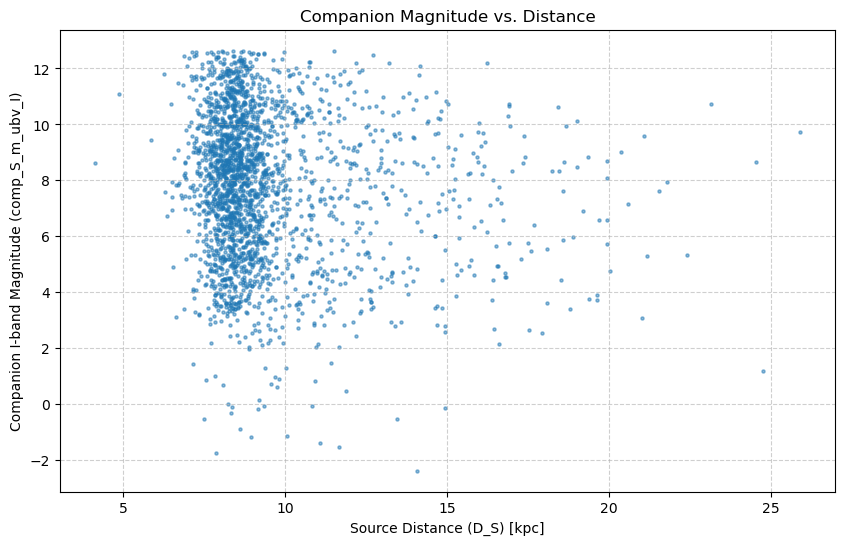

In [18]:
import matplotlib.pyplot as plt

# We need to drop any rows where the companion magnitude is NaN to avoid errors
subset = filtered_df_with_calcs.dropna(subset=['comp_S_m_ubv_I', 'D_S'])

plt.figure(figsize=(10, 6))
plt.scatter(subset['D_S'], subset['comp_S_m_ubv_I'], alpha=0.5, s=5)
plt.xlabel('Source Distance (D_S) [kpc]')
plt.ylabel('Companion I-band Magnitude (comp_S_m_ubv_I)')
plt.title('Companion Magnitude vs. Distance')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Cool, so it's definately absolute magnitude.

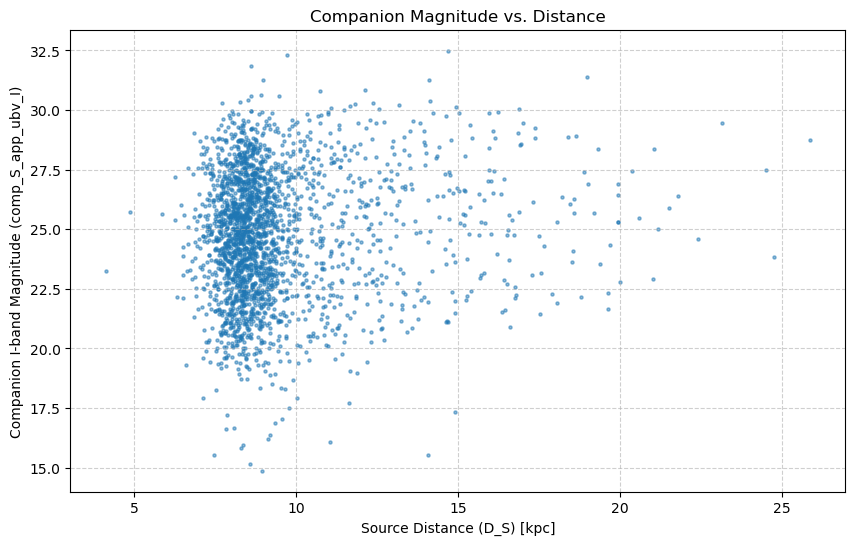

In [19]:
# We need to drop any rows where the companion magnitude is NaN to avoid errors
subset2 = filtered_df_with_calcs.dropna(subset=['comp_S_app_ubv_I', 'D_S'])

plt.figure(figsize=(10, 6))
plt.scatter(subset2['D_S'], subset['comp_S_app_ubv_I'], alpha=0.5, s=5)
plt.xlabel('Source Distance (D_S) [kpc]')
plt.ylabel('Companion I-band Magnitude (comp_S_app_ubv_I)')
plt.title('Companion Magnitude vs. Distance')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Why is that barely correlated? Oh, well. The values look more reasonable for apparent magnitudes now, so lets just run with it. That's not a lot of starts brighter than 17.5, though.

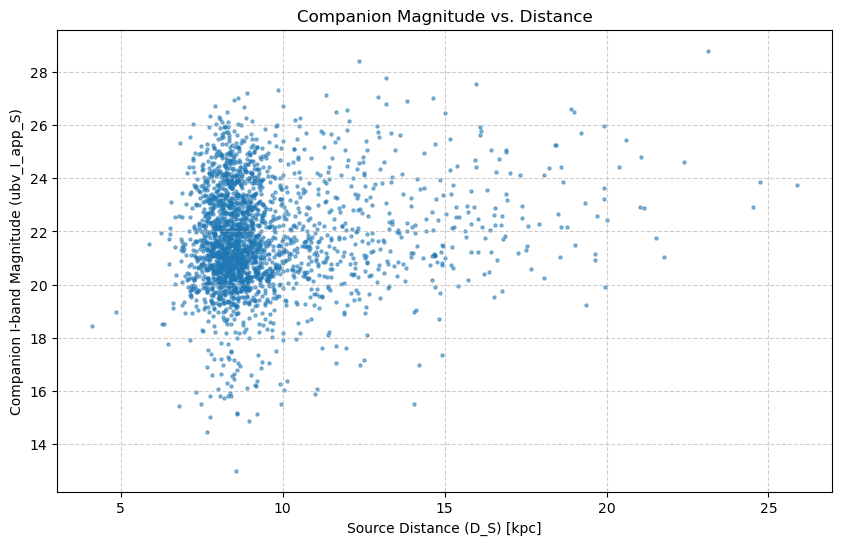

In [20]:
subset2 = filtered_df_with_calcs.dropna(subset=['ubv_I_app_S', 'D_S'])

plt.figure(figsize=(10, 6))
plt.scatter(subset2['D_S'], subset2['ubv_I_app_S'], alpha=0.5, s=5)
plt.xlabel('Source Distance (D_S) [kpc]')
plt.ylabel('Companion I-band Magnitude (ubv_I_app_S)')
plt.title('Companion Magnitude vs. Distance')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

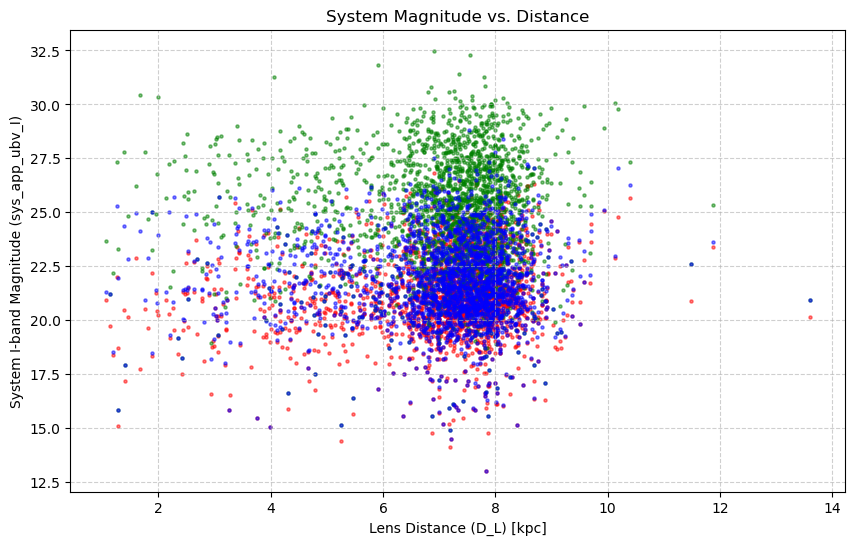

In [21]:
subset3 = filtered_df_with_calcs.dropna(subset=['sys_app_ubv_I', 'comp_S_app_ubv_I', 'ubv_I_app_S', 'D_L'])

plt.figure(figsize=(10, 6))
plt.scatter(subset3['D_L'], subset3['sys_app_ubv_I'], alpha=0.5, s=5, c='r', label='System Mag')
plt.scatter(subset3['D_L'], subset3['comp_S_app_ubv_I'], alpha=0.5, s=5, c='g', label='Companion Mag')
plt.scatter(subset3['D_L'], subset3['ubv_I_app_S'], alpha=0.5, s=5, c='b', label='Source Mag')
plt.xlabel('Lens Distance (D_L) [kpc]')
plt.ylabel('System I-band Magnitude (sys_app_ubv_I)')
plt.title('System Magnitude vs. Distance')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

I mean the distribution of distances looks the same. Maybe we can just ignore the magnitude cut.

## Select and Rename to Create the Final, Clean Table

In [22]:
# This is our blueprint for the final product. No junk allowed.
final_columns = {
    'mass_L': 'M_L',
    'D_L': 'D_L_kpc',
    'D_S': 'D_S_kpc',
    'mu_rel': 'mu_rel_mas_yr',
    'theta_E': 'theta_E_mas',
    'u0': 'u0',  # The impact parameter, in units of thet
    'comp_S_sep': 'binary_sep_au', # The physical separation in AU
    'comp_S_log_a': 'binary_log_a_au', 
    'binary_a_au': 'binary_a_au',
    'comp_S_alpha': 'binary_alpha_deg',
    'comp_S_phi': 'binary_phi_deg',
    'binary_angular_separation': 'binary_sep_arcsec', # The angular separation
    'glon_S': 'gal_lon_S_deg',
    'glat_S': 'gal_lat_S_deg',
    'ubv_I_S': 'I_S',
    'comp_S_m_ubv_I': 'I_S2',
    'ubv_I_L': 'I_L',
    'comp_L_m_ubv_I': 'I_L2',
    'L_mag_S': 'L_S',
    'L_mag_comp_S': 'L_S2',
    'L_mag_L': 'L_L',
    'L_mag_comp_L': 'L_L2',
    'mu_b_L': 'mu_b_L',
    'mu_lcosb_L': 'mu_lcosb_L',
    'mu_b_S': 'mu_b_S',
    'mu_lcosb_S': 'mu_lcosb_S',
    # include event_id generated earlier so it persists into the final output
    'event_id': 'event_id'
}

# Create the final table from your filtered data.
# This selects ONLY the columns we want and renames them.
renamed_table = filtered_df_with_calcs[list(final_columns.keys())].rename(columns=final_columns)

renamed_table.head()

KeyError: "['event_id'] not in index"

## Save the Final Table

In [ ]:
# save the final table to a csv file with a header
renamed_table.to_csv('data/popsycle_table_with_calcs.csv', index=False)

## How to Use this Table

In [ ]:
# Load the table
table = pd.read_csv('data/popsycle_table_with_calcs.csv')

# Print the first few rows of the table
table.head()

,M_L,D_L_kpc,D_S_kpc,mu_rel_mas_yr,theta_E_mas,u0,binary_sep_au,binary_log_a_au,binary_a_au,binary_alpha_deg,...,L_S,L_S2,L_L,L_L2,mu_b_L,mu_lcosb_L,mu_b_S,mu_lcosb_S,I_sys,L_sys
0,0.108094,1.059379,8.349576,14.859446,0.850656,0.457256,0.002759,-1.456608,0.034946,145.180702,...,19.016959,20.506999,NaN,NaN,5.178126,0.893861,-4.265777,-10.578534,20.922263,18.771645
1,0.310635,4.306824,7.832075,11.668156,0.513506,-1.884719,1.569128,1.339302,21.842480,45.090036,...,19.308044,NaN,20.064318,NaN,-1.728731,1.301230,4.807209,-8.364552,15.857329,18.869047
2,0.119087,4.632275,10.512844,4.986551,0.341765,-0.076806,0.010222,0.268963,1.857648,139.491598,...,21.446788,23.441573,22.477729,NaN,1.330784,-6.175443,-0.663528,-10.745827,23.991133,20.973642
3,0.256288,6.178383,7.294702,2.289019,0.227061,1.102258,0.068878,0.612039,4.092978,291.545738,...,17.815908,21.010838,21.095021,NaN,-0.455825,-5.559121,-1.647413,-3.604709,19.928434,17.710928
4,0.109863,6.538958,8.791398,8.926219,0.186987,1.132633,21.375443,2.445328,278.822644,75.633166,...,17.913674,23.551280,NaN,NaN,3.738406,-2.511558,-0.256501,-10.493921,19.954963,17.907655


In [ ]:
print(table.shape)

(2389, 28)


In [ ]:
# how to use one column
D_L = table['D_L_kpc']

In [ ]:
# how to filter the table
table_filtered = table[table['D_L_kpc'] < 20]

# how to add a new column
table['D_L_pc'] = table['D_L_kpc'] * 1000

In [ ]:
table_filtered = table_filtered[table_filtered['I_S'] < 18.0]

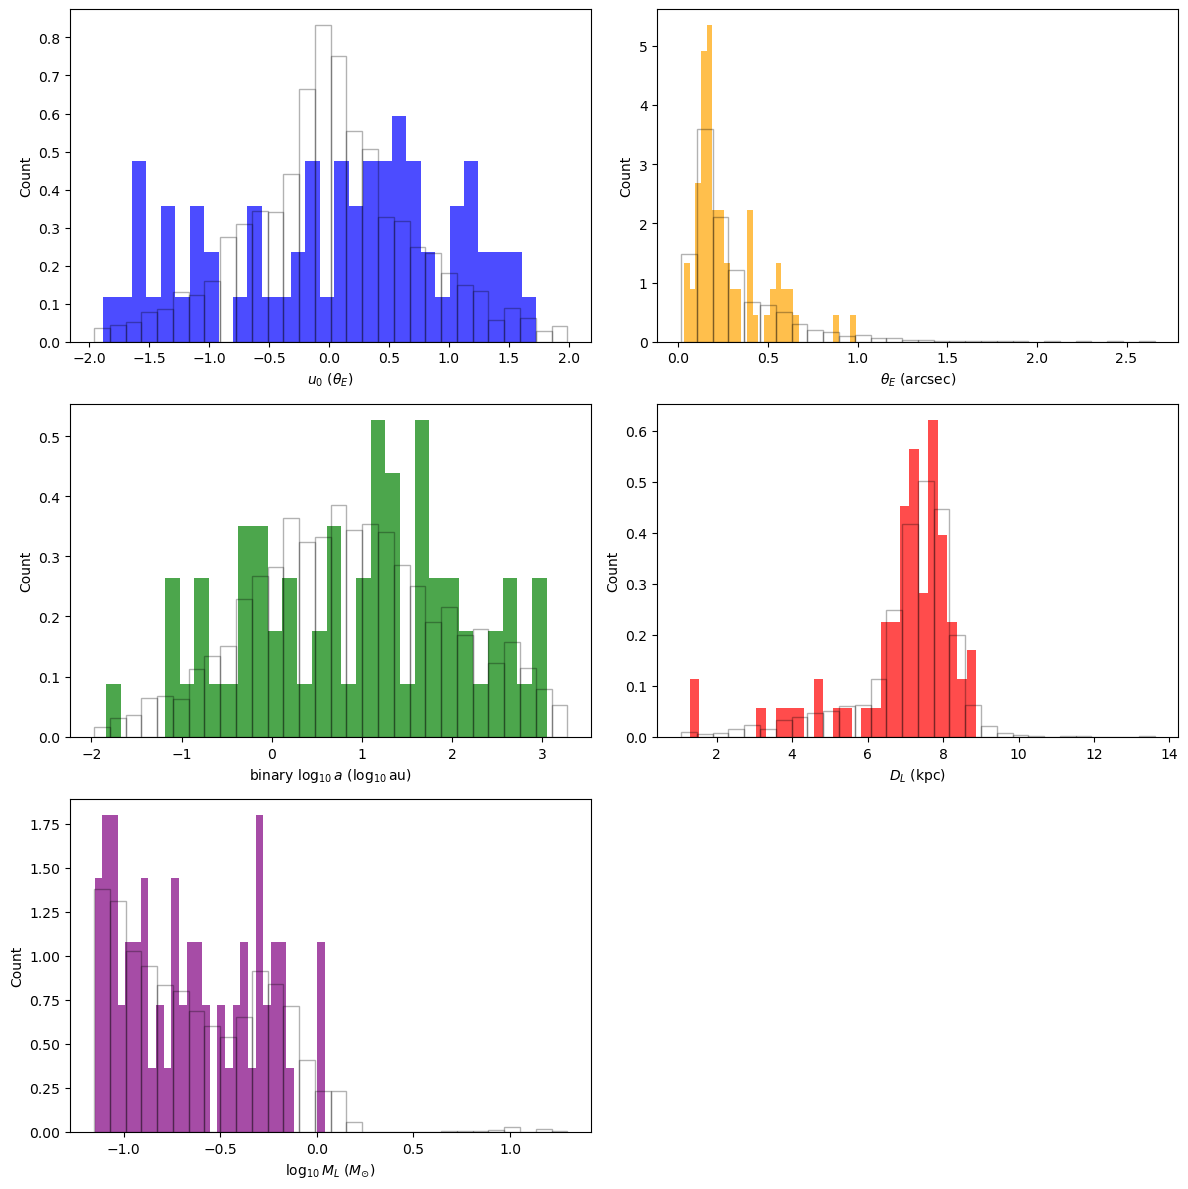

In [ ]:
# plot table filtered histograms
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

# Normalized Histogram for u0
plt.subplot(3, 2, 1)
plt.hist(table_filtered['u0'], bins=30, color='blue', alpha=0.7, density=True)
plt.hist(table['u0'], bins=30, edgecolor='black', fill=False, alpha=0.3, density=True)
plt.xlabel(r'$u_{0}$ ($\theta_{E}$)')
plt.ylabel('Count')

# Histogram for theta_E
plt.subplot(3, 2, 2)
plt.hist(table_filtered['theta_E_mas'], bins=30, color='orange', alpha=0.7, density=True)
plt.hist(table['theta_E_mas'], bins=30, edgecolor='black', fill=False, alpha=0.3, density=True)
plt.xlabel(r'$\theta_{E}$ (arcsec)')
plt.ylabel('Count')

# Histogram for binary_log_a_au
plt.subplot(3, 2, 3)
plt.hist(table_filtered['binary_log_a_au'], bins=30, color='green', alpha=0.7, density=True)
plt.hist(table['binary_log_a_au'], bins=30, edgecolor='black', fill=False, alpha=0.3, density=True)
plt.xlabel(r'binary $\log_{10}{a}$ ($\log_{10}\mathrm{au}$)')
plt.ylabel('Count')

# Histogram for D_L
plt.subplot(3, 2, 4)
plt.hist(table_filtered['D_L_kpc'], bins=30, color='red', alpha=0.7, density=True)
plt.hist(table['D_L_kpc'], bins=30, edgecolor='black', fill=False, alpha=0.3, density=True)
plt.xlabel(r'$D_{L}$ (kpc)')
plt.ylabel('Count')

# Histogram for M_L
plt.subplot(3, 2, 5)
plt.hist(np.log10(table_filtered['M_L']), bins=30, color='purple', alpha=0.7, density=True)
plt.hist(np.log10(table['M_L']), bins=30, edgecolor='black', fill=False, alpha=0.3, density=True)
plt.xlabel(r'$\log_{10}{M_{L}}$ ($M_{\odot}$)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
# how to make a numpy array
D_L_array = table['D_L_kpc'].to_numpy()

In [ ]:
# Create a DataFrame with phi values from 0 to 179 (inclusive)
phi_values = pd.DataFrame({'phi': np.arange(0, 180, 1)})

# Add a temporary key to both DataFrames for the cross join
table['key'] = 1
phi_values['key'] = 1

# Perform the cross join
expanded_table = pd.merge(table, phi_values, on='key').drop('key', axis=1)

# Now, expanded_table contains every row of 'table' repeated for each phi value

# Using .to_numpy() (recommended)
array = expanded_table.to_numpy()

# Or, equivalently:
# array = expanded_table.values

print(array)

[[1.08094245e-01 1.05937888e+00 8.34957595e+00 ... 1.87716454e+01
  1.05937888e+03 0.00000000e+00]
 [1.08094245e-01 1.05937888e+00 8.34957595e+00 ... 1.87716454e+01
  1.05937888e+03 1.00000000e+00]
 [1.08094245e-01 1.05937888e+00 8.34957595e+00 ... 1.87716454e+01
  1.05937888e+03 2.00000000e+00]
 ...
 [5.31918201e-01 7.88608313e+00 9.37316887e+00 ...            nan
  7.88608313e+03 1.77000000e+02]
 [5.31918201e-01 7.88608313e+00 9.37316887e+00 ...            nan
  7.88608313e+03 1.78000000e+02]
 [5.31918201e-01 7.88608313e+00 9.37316887e+00 ...            nan
  7.88608313e+03 1.79000000e+02]]


This is just an example. Obviously, you will need more columns than this.

In [ ]:
# ensure a datatype and select the columns we want
array_typed = expanded_table[['D_L_kpc', 'D_S_kpc', 'phi']].to_numpy(dtype=float)

print(array_typed.shape)

(430020, 3)


You can use this kind of repeating array to avoid loops in your calculations.

## Sanity Checks

<!-- from astropy.io import fits
fits_file = 'data/all_fields_Mrun_EWS_w_comp_params.fits'
with fits.open(fits_file) as hdul:
    data = hdul[1].data
    data_array = np.array(data).byteswap().view(data.dtype.newbyteorder('='))
    df = pd.DataFrame(data_array) -->

The `a` (semi-major axis) should not be greater than `sep` (projected separation). The code above prints the number of cases where this is violated.

In [ ]:
mask = table['binary_a_au'] > table['binary_sep_au']
print(f'Number of cases where a > sep: {mask.sum()} / {len(table)}')

Number of cases where a > sep: 2389 / 2389




**Histograms:** For `binary_log_a_au` and `binary_sep_au` to help you visually inspect the distributions.

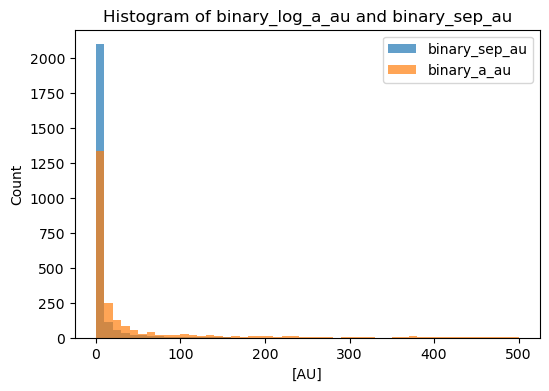

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(table['binary_sep_au'].dropna(), range=(0, 500), bins=50, alpha=0.7, label='binary_sep_au')
plt.hist(table['binary_a_au'].dropna(), range=(0, 500), bins=50, alpha=0.7, label='binary_a_au')
plt.xlabel('[AU]')
plt.ylabel('Count')
plt.title('Histogram of binary_log_a_au and binary_sep_au')
plt.legend()
plt.show()

Looks good!

Lets check the L-band transformation next.

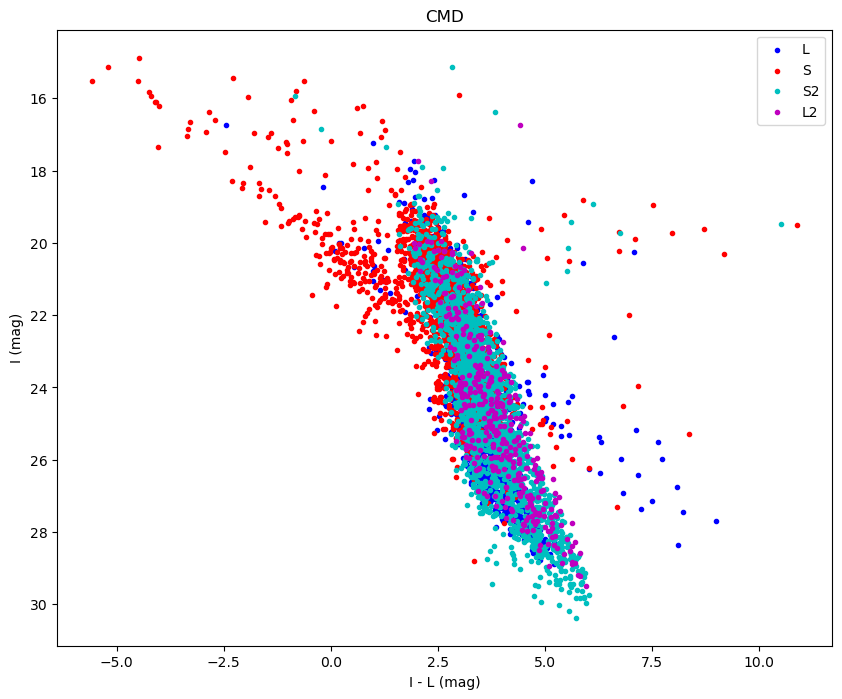

In [ ]:
# Colour magnitude diagram
renamed_table['IL_L'] = renamed_table['I_L']- renamed_table['L_L']
renamed_table['IL_S'] = renamed_table['I_S'] - renamed_table['L_S']
renamed_table['IL_S2'] = renamed_table['I_S2'] - renamed_table['L_S2']
renamed_table['IL_L2'] = renamed_table['I_L2'] - renamed_table['L_L2']

# Plot the CMD
plt.figure(figsize=(10, 8))
plt.scatter(renamed_table['IL_L'], renamed_table['I_L'], c='b', marker='.', label='L')
plt.scatter(renamed_table['IL_S'], renamed_table['I_S'], c='r', marker='.', label='S')
plt.scatter(renamed_table['IL_S2'], renamed_table['I_S2'], c='c', marker='.', label='S2')
plt.scatter(renamed_table['IL_L2'], renamed_table['I_L2'], c='m', marker='.', label='L2')
plt.xlabel('I - L (mag)')
plt.ylabel('I (mag)')
plt.legend()
plt.title('CMD')

# And for God's sake, invert the y-axis. Brighter stars go at the top.
plt.gca().invert_yaxis()


plt.show()

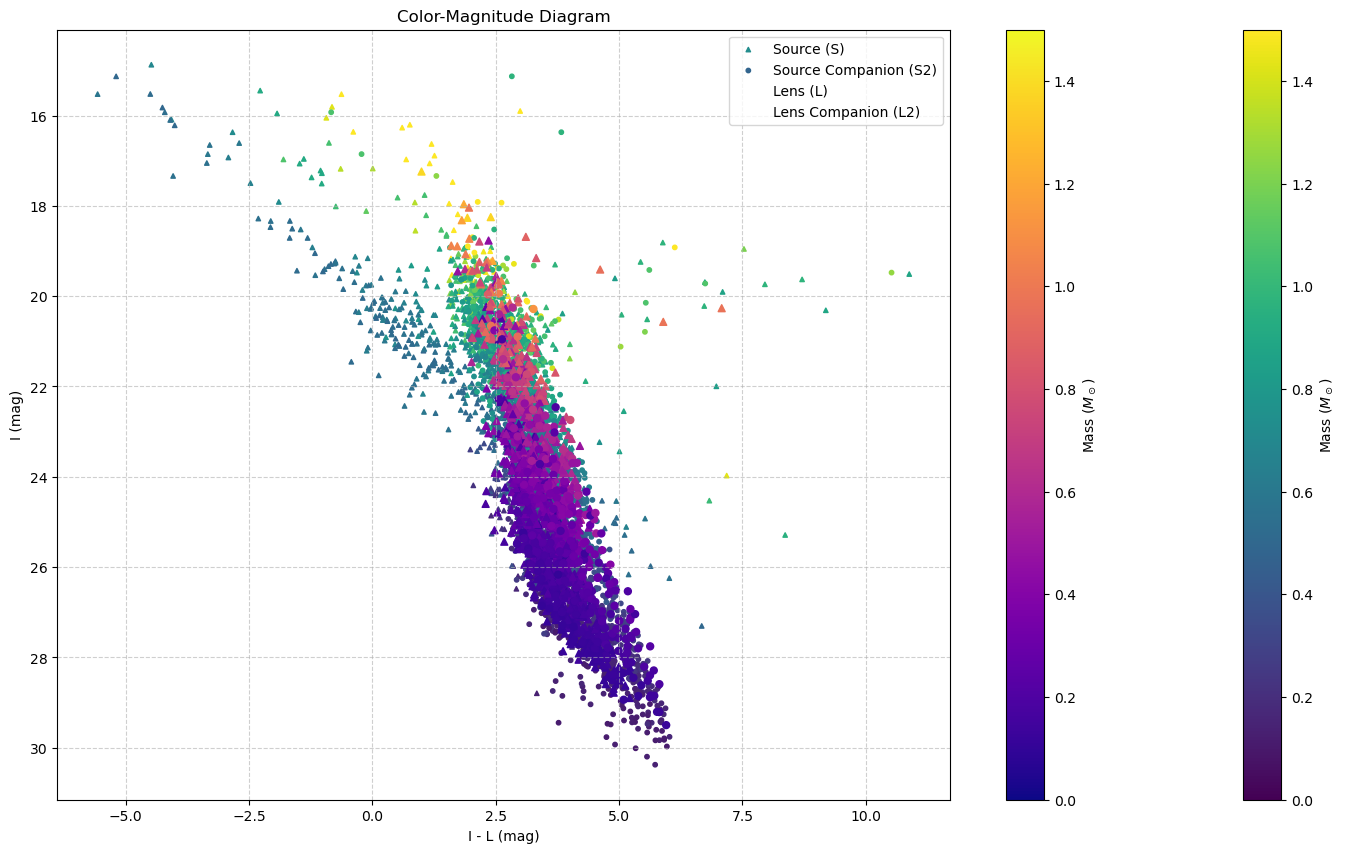

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Data Preparation ---
# Calculate the color for each population from the intermediate DataFrame
color_S = filtered_df_with_calcs['ubv_I_app_S'] - filtered_df_with_calcs['L_mag_S']
color_S2 = filtered_df_with_calcs['comp_S_app_ubv_I'] - filtered_df_with_calcs['L_mag_comp_S']
color_L = filtered_df_with_calcs['ubv_I_app_L'] - filtered_df_with_calcs['L_mag_L']
color_L2 = filtered_df_with_calcs['comp_L_app_ubv_I'] - filtered_df_with_calcs['L_mag_comp_L']

# --- Plotting ---
plt.figure(figsize=(18, 10))

# Create the scatter plot, using mass for the color
# The 'c' argument takes the mass values, and 'cmap' sets the color scheme
sc = plt.scatter(color_S, filtered_df_with_calcs['ubv_I_app_S'], 
                 c=filtered_df_with_calcs['mass_S'], 
                 cmap='viridis', s=10, marker='^', label='Source (S)', vmin=0, vmax=1.5)

plt.scatter(color_S2, filtered_df_with_calcs['comp_S_app_ubv_I'], 
            c=filtered_df_with_calcs['comp_S_mass'], 
            cmap='viridis', s=10, marker='o', label='Source Companion (S2)', vmin=0, vmax=1.5)

#"""
# We only plot lenses that are actual stars (rem_id_L == 0)
lens_star_mask = filtered_df_with_calcs['rem_id_L'] == 0

sc2 = plt.scatter(color_L[lens_star_mask], filtered_df_with_calcs['ubv_I_app_L'][lens_star_mask], 
            c=filtered_df_with_calcs['mass_L'][lens_star_mask],
            cmap='plasma', s=25, marker='^', label='Lens (L)', vmin=0, vmax=1.5)

plt.scatter(color_L2[lens_star_mask], filtered_df_with_calcs['comp_L_app_ubv_I'][lens_star_mask], 
            c=filtered_df_with_calcs['comp_L_mass'][lens_star_mask],
            cmap='plasma', s=25, marker='o', label='Lens Companion (L2)', vmin=0, vmax=1.5)
#"""

"""
sc2 = plt.scatter(color_L, filtered_df_with_calcs['ubv_I_app_L'], 
            c=filtered_df_with_calcs['mass_L'],
            cmap='plasma', s=25, marker='^', label='Lens (L)', vmin=0, vmax=1.5, alpha=0.5)

plt.scatter(color_L2, filtered_df_with_calcs['comp_L_app_ubv_I'], 
            c=filtered_df_with_calcs['comp_L_mass'],
            cmap='plasma', s=25, marker='o', label='Lens Companion (L2)', vmin=0, vmax=1.5, alpha=0.5)
#"""


# Add a colorbar and label it properly
cbar = plt.colorbar(sc, label='Mass ($M_\\odot$)')
cbar = plt.colorbar(sc2, label='Mass ($M_\\odot$)')


# --- Final Touches ---
plt.xlabel('I - L (mag)')
plt.ylabel('I (mag)')
plt.title('Color-Magnitude Diagram')
plt.legend()

# Set plot limits to zoom in on the main sequence and ignore outliers
#plt.xlim(-2, 6)
plt.gca().invert_yaxis() # Flipped y-axis for a proper CMD

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

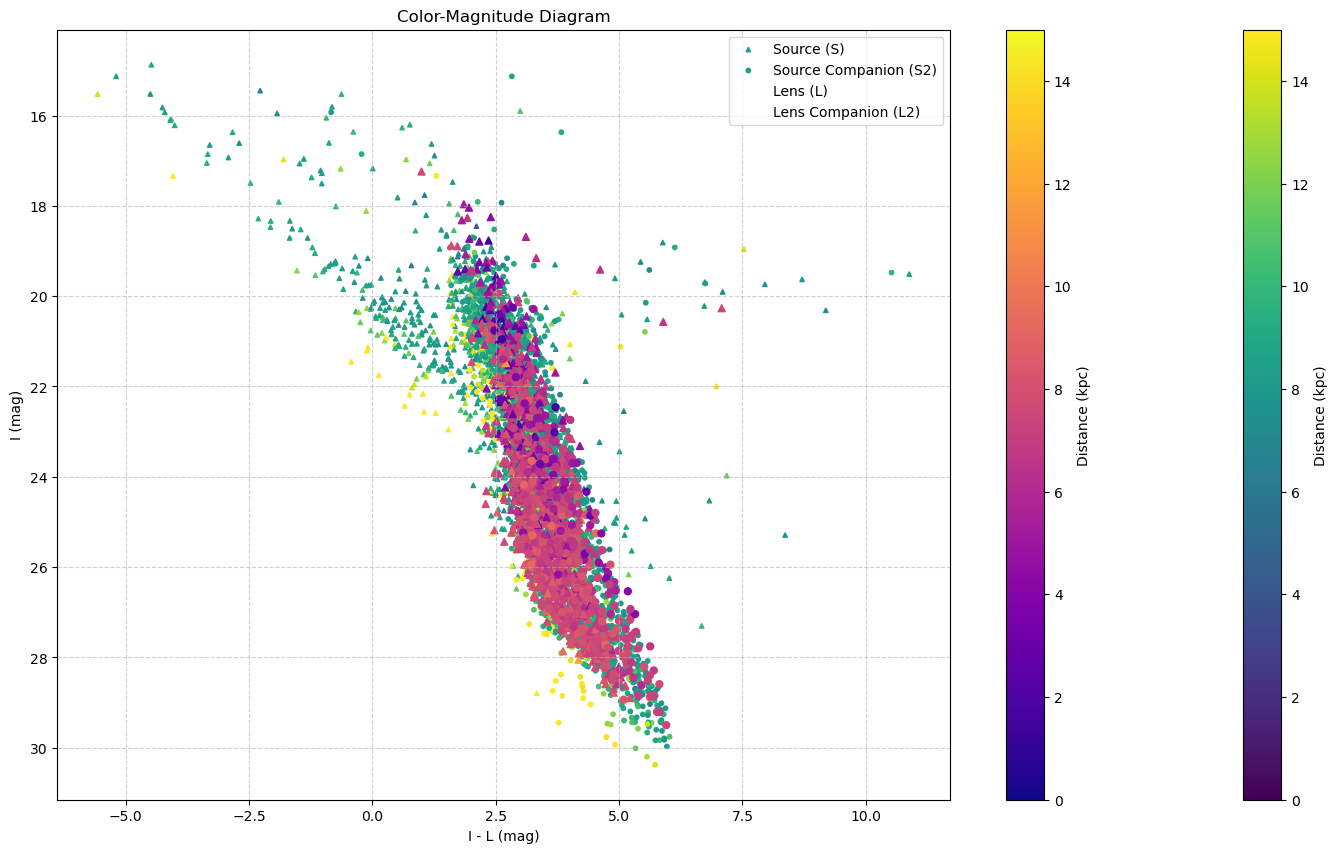

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Data Preparation ---
# Calculate the color for each population from the intermediate DataFrame
color_S = filtered_df_with_calcs['ubv_I_app_S'] - filtered_df_with_calcs['L_mag_S']
color_S2 = filtered_df_with_calcs['comp_S_app_ubv_I'] - filtered_df_with_calcs['L_mag_comp_S']
color_L = filtered_df_with_calcs['ubv_I_app_L'] - filtered_df_with_calcs['L_mag_L']
color_L2 = filtered_df_with_calcs['comp_L_app_ubv_I'] - filtered_df_with_calcs['L_mag_comp_L']

# --- Plotting ---
plt.figure(figsize=(18, 10))

# Create the scatter plot, using mass for the color
# The 'c' argument takes the mass values, and 'cmap' sets the color scheme
sc = plt.scatter(color_S, filtered_df_with_calcs['ubv_I_app_S'], 
                 c=filtered_df_with_calcs['D_S'], 
                 cmap='viridis', s=10, marker='^', label='Source (S)', vmin=0, vmax=15)

plt.scatter(color_S2, filtered_df_with_calcs['comp_S_app_ubv_I'], 
            c=filtered_df_with_calcs['D_S'], 
            cmap='viridis', s=10, marker='o', label='Source Companion (S2)', vmin=0, vmax=15)

#"""
# We only plot lenses that are actual stars (rem_id_L == 0)
lens_star_mask = filtered_df_with_calcs['rem_id_L'] == 0

sc2 = plt.scatter(color_L[lens_star_mask], filtered_df_with_calcs['ubv_I_app_L'][lens_star_mask], 
            c=filtered_df_with_calcs['D_L'][lens_star_mask],
            cmap='plasma', s=25, marker='^', label='Lens (L)', vmin=0, vmax=15)

plt.scatter(color_L2[lens_star_mask], filtered_df_with_calcs['comp_L_app_ubv_I'][lens_star_mask], 
            c=filtered_df_with_calcs['D_L'][lens_star_mask],
            cmap='plasma', s=25, marker='o', label='Lens Companion (L2)', vmin=0, vmax=15)
#"""

"""
sc2 = plt.scatter(color_L, filtered_df_with_calcs['ubv_I_app_L'], 
            c=filtered_df_with_calcs['mass_L'],
            cmap='plasma', s=25, marker='^', label='Lens (L)', vmin=0, vmax=1.5, alpha=0.5)

plt.scatter(color_L2, filtered_df_with_calcs['comp_L_app_ubv_I'], 
            c=filtered_df_with_calcs['comp_L_mass'],
            cmap='plasma', s=25, marker='o', label='Lens Companion (L2)', vmin=0, vmax=1.5, alpha=0.5)
#"""


# Add a colorbar and label it properly
cbar = plt.colorbar(sc, label='Distance (kpc)')
cbar = plt.colorbar(sc2, label='Distance (kpc)')


# --- Final Touches ---
plt.xlabel('I - L (mag)')
plt.ylabel('I (mag)')
plt.title('Color-Magnitude Diagram')
plt.legend()

# Set plot limits to zoom in on the main sequence and ignore outliers
#plt.xlim(-2, 6)
plt.gca().invert_yaxis() # Flipped y-axis for a proper CMD

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

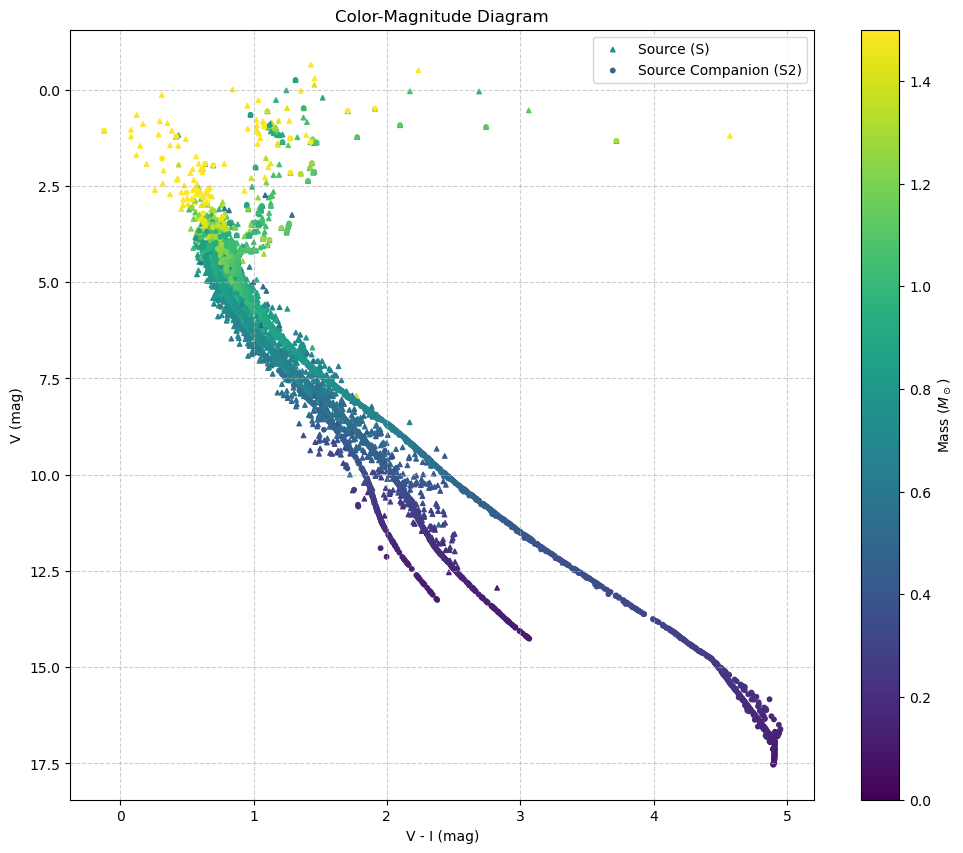

In [ ]:
# --- Data Preparation ---
# Calculate the color for each population from the intermediate DataFrame
color_S = filtered_df_with_calcs['ubv_V_S'] - filtered_df_with_calcs['ubv_I_S']
color_S2 = filtered_df_with_calcs['comp_S_m_ubv_V'] - filtered_df_with_calcs['comp_S_m_ubv_I']
color_L = filtered_df_with_calcs['ubv_V_L'] - filtered_df_with_calcs['ubv_I_L']
color_L2 = filtered_df_with_calcs['comp_L_m_ubv_V'] - filtered_df_with_calcs['comp_L_m_ubv_I']

# --- Plotting ---
plt.figure(figsize=(12, 10))

# Create the scatter plot, using mass for the color
# The 'c' argument takes the mass values, and 'cmap' sets the color scheme
sc = plt.scatter(color_S, filtered_df_with_calcs['ubv_V_S'], 
                 c=filtered_df_with_calcs['mass_S'], 
                 cmap='viridis', s=10, marker='^', label='Source (S)', vmin=0, vmax=1.5)

plt.scatter(color_S2, filtered_df_with_calcs['comp_S_m_ubv_V'], 
            c=filtered_df_with_calcs['comp_S_mass'], 
            cmap='viridis', s=10, marker='o', label='Source Companion (S2)', vmin=0, vmax=1.5)

"""
# We only plot lenses that are actual stars (rem_id_L == 0)
lens_star_mask = filtered_df_with_calcs['rem_id_L'] == 0

sc2 = plt.scatter(color_L[lens_star_mask], filtered_df_with_calcs['ubv_I_L'][lens_star_mask], 
            c=filtered_df_with_calcs['mass_L'][lens_star_mask],
            cmap='plasma', s=25, marker='^', label='Lens (L)', vmin=0, vmax=1.5)

plt.scatter(color_L2[lens_star_mask], filtered_df_with_calcs['comp_L_m_ubv_I'][lens_star_mask], 
            c=filtered_df_with_calcs['comp_L_mass'][lens_star_mask],
            cmap='plasma', s=25, marker='^', label='Lens Companion (L2)', vmin=0, vmax=1.5)
#"""

"""
sc2 = plt.scatter(color_L, filtered_df_with_calcs['ubv_V_L'], 
            c=filtered_df_with_calcs['mass_L'],
            cmap='plasma', s=25, marker='^', label='Lens (L)', vmin=0, vmax=1.5)

plt.scatter(color_L2, filtered_df_with_calcs['comp_L_m_ubv_V'], 
            c=filtered_df_with_calcs['comp_L_mass'],
            cmap='plasma', s=25, marker='o', label='Lens Companion (L2)', vmin=0, vmax=1.5)
#"""

# Add a colorbar and label it properly
cbar = plt.colorbar(sc, label='Mass ($M_\\odot$)')
#cbar = plt.colorbar(sc2, label='Mass ($M_\\odot$)')

# --- Final Touches ---
plt.xlabel('V - I (mag)')
plt.ylabel('V (mag)')
plt.title('Color-Magnitude Diagram')
plt.legend()

# Set plot limits to zoom in on the main sequence and ignore outliers
#plt.xlim(-2, 6)
plt.gca().invert_yaxis() # Flipped y-axis for a proper CMD

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Use this next plot to see which ones are remnants.

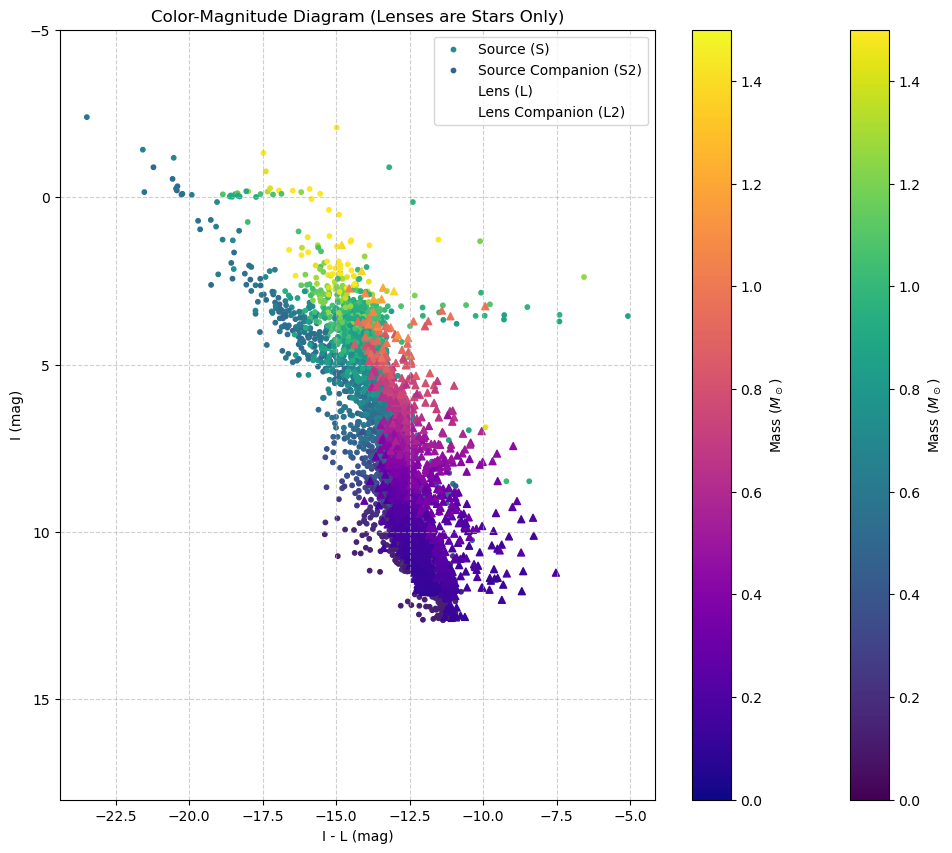

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Data Preparation ---
# Calculate the color for each population
color_S = filtered_df_with_calcs['ubv_I_S'] - filtered_df_with_calcs['L_mag_S']
color_S2 = filtered_df_with_calcs['comp_S_m_ubv_I'] - filtered_df_with_calcs['L_mag_comp_S']
color_L = filtered_df_with_calcs['ubv_I_L'] - filtered_df_with_calcs['L_mag_L']
color_L2 = filtered_df_with_calcs['comp_L_m_ubv_I'] - filtered_df_with_calcs['L_mag_comp_L']

# --- Create a mask to select ONLY stars for the lens populations ---
lens_is_star_mask = filtered_df_with_calcs['rem_id_L'] == 0
# 0 - star
# 101 - white dwarf
# 102 - neutron star
# 103 - black hole

# --- Plotting ---
plt.figure(figsize=(12, 10))

# Plot Sources (no change here)
sc = plt.scatter(color_S, filtered_df_with_calcs['ubv_I_S'],
                 c=filtered_df_with_calcs['mass_S'],
                 cmap='viridis', s=10, label='Source (S)', vmin=0, vmax=1.5)

plt.scatter(color_S2, filtered_df_with_calcs['comp_S_m_ubv_I'],
            c=filtered_df_with_calcs['comp_S_mass'],
            cmap='viridis', s=10, label='Source Companion (S2)', vmin=0, vmax=1.5)

# Plot Lenses using the new mask
sc2 = plt.scatter(color_L[lens_is_star_mask], filtered_df_with_calcs['ubv_I_L'][lens_is_star_mask],
            c=filtered_df_with_calcs['mass_L'][lens_is_star_mask],
            cmap='plasma', s=25, marker='^', label='Lens (L)', vmin=0, vmax=1.5)

plt.scatter(color_L2[lens_is_star_mask], filtered_df_with_calcs['comp_L_m_ubv_I'][lens_is_star_mask],
            c=filtered_df_with_calcs['comp_L_mass'][lens_is_star_mask],
            cmap='plasma', s=25, marker='^', label='Lens Companion (L2)', vmin=0, vmax=1.5)

# --- Final Touches ---
cbar = plt.colorbar(sc, label='Mass ($M_\\odot$)')
cbar = plt.colorbar(sc2, label='Mass ($M_\\odot$)')
plt.xlabel('I - L (mag)')
plt.ylabel('I (mag)')
plt.title('Color-Magnitude Diagram (Lenses are Stars Only)')
plt.legend()
plt.ylim(18, -5) # Flipped y-axis for a proper CMD
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
print(filtered_df_with_calcs['rem_id_L'].unique())

[  0 101 102 103]


## Units

Be careful that the unit's in this table match those your code is expecting. Forgetting your units is a sin you don't want to commit. It's the difference between a discovery and a disaster.

| Your Column Name | Original Column(s) | Units |
| :--- | :--- | :--- |
| `M_L` | `mass_L` | Solar Masses ($M_\odot$) |
| `D_L_kpc` | `px_L`, `py_L`, `pz_L` | Kiloparsecs (kpc) |
| `D_S_kpc` | `px_S`, `py_S`, `pz_S` | Kiloparsecs (kpc) |
| `mu_rel_mas_yr` | `mu_rel` | Milliarcseconds per year (mas/yr) |
| `theta_E_mas` | `theta_E` | Milliarcseconds (mas) |
| `u0` | `u0` | $\theta_E$ |
| `binary_sep_au` | `comp_S_sep` | Projected separation (AU) |
| `binary_log_a_au` | `comp_S_log_a` | log10(semi-major axis/AU) |
| `binary_a_au` | `comp_S_log_a` | Semi-major axis (AU) |
| `binary_alpha_deg` | `comp_S_alpha` | Orientation angle (deg) |
| `binary_phi_deg` | `comp_S_phi` | Phase angle (deg) |
| `binary_sep_arcsec` | `comp_S_sep`, `D_S` | Projected separation (arcsec) |
| `gal_lon_S_deg` | `glon_S` | Galactic longitude (deg) |
| `gal_lat_S_deg` | `glat_S` | Galactic latitude (deg) |
| `I_S` | `ubv_I_S` | Source I-band magnitude |
| `I_S2` | `comp_S_m_ubv_I` | Source companion I-band magnitude |
| `mu_b_L` | `mu_b_L` | Lens proper motion in b direction (mas/yr) |
| `mu_lcosb_L` | `mu_lcosb_L` | Lens proper motion in l*cos(b) direction (mas/yr) |
| `mu_b_S` | `mu_b_S` | Source proper motion in b direction (mas/yr) |
| `mu_lcosb_S` | `mu_lcosb_S` | Source proper motion in l*cos(b) direction (mas/yr) |
